In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Bidirectional
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive
from google.colab import drive
# data_path = '/home/arsh/Jasleen/Spring 2023/NLP/Group Project/Authorship-Attribution-for-Neural-Text-Generation-master/data/'
from google.colab import drive
drive.mount('/content/drive')
data_path = 'drive/MyDrive/NLP/'
data = pd.read_csv(data_path+'input.csv')





Mounted at /content/drive


In [2]:
texts = data['text'].tolist()
classes = data['class'].tolist()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tokenized_texts = [word_tokenize(text.lower()) for text in texts]
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

preprocessed_texts = []
for tokens in tokenized_texts:
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token not in punctuation]
    preprocessed_texts.append(filtered_tokens)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(preprocessed_texts)
max_sequence_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(set(classes))
one_hot_classes = to_categorical(encoded_classes, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_classes, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model2.add(LSTM(128))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Epoch 1/5
74/74 [==============================] - 35s 281ms/step - loss: 1.7421 - accuracy: 0.3640 - val_loss: 1.1298 - val_accuracy: 0.5763
Epoch 2/5
74/74 [==============================] - 17s 228ms/step - loss: 0.8623 - accuracy: 0.6892 - val_loss: 0.8763 - val_accuracy: 0.6731
Epoch 3/5
74/74 [==============================] - 17s 234ms/step - loss: 0.5372 - accuracy: 0.8033 - val_loss: 0.7422 - val_accuracy: 0.7302
Epoch 4/5
74/74 [==============================] - 15s 200ms/step - loss: 0.2752 - accuracy: 0.9106 - val_loss: 0.7685 - val_accuracy: 0.7477
Epoch 5/5
74/74 [==============================] - 16s 218ms/step - loss: 0.1095 - accuracy: 0.9710 - val_loss: 0.8371 - val_accuracy: 0.7630
Epoch 1/5
74/74 [==============================] - 23s 277ms/step - loss: 2.0775 - accuracy: 0.2630 - val_loss: 1.6280 - val_accuracy: 0.3657
Epoch 2/5
74/74 [==============================] - 17s 229ms/step - loss: 1.3093 - accuracy: 0.4970 - val_loss: 1.2162 - val_accuracy: 0.5580
Epoch 

In [3]:
cnn_lstm_predictions = model.predict(X_test)
lstm_rnn_predictions = model2.predict(X_test)

combined_predictions = []
for i in range(len(cnn_lstm_predictions)):
    combined_predictions.append(np.argmax(cnn_lstm_predictions[i] + lstm_rnn_predictions[i]))

combined_accuracy = accuracy_score(np.argmax(y_test, axis=1), combined_predictions)
print("Combined model accuracy:", combined_accuracy)

print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), combined_predictions,target_names=label_encoder.classes_))

74/74 [==============================] - 1s 7ms/step
Combined model accuracy: 0.7617220801364024
Classification Report:
              precision    recall  f1-score   support

        ctrl       0.95      0.94      0.95       214
        fair       0.51      0.75      0.60       209
         gpt       0.99      1.00      1.00       217
        gpt2       0.58      0.62      0.60       213
        gpt3       0.48      0.50      0.49       217
      grover       0.65      0.64      0.64       222
       human       0.81      0.65      0.73       220
 instructgpt       0.74      0.62      0.68       202
        pplm       0.90      0.70      0.79       206
         xlm       0.99      0.98      0.98       215
       xlnet       0.96      0.98      0.97       211

    accuracy                           0.76      2346
   macro avg       0.78      0.76      0.77      2346
weighted avg       0.78      0.76      0.77      2346



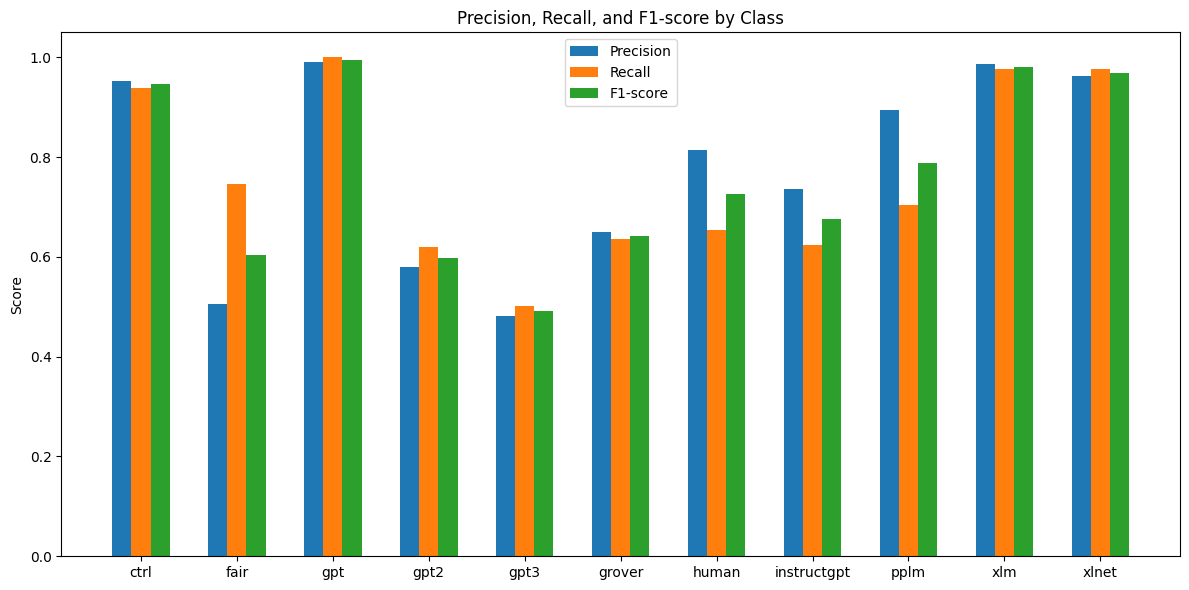

In [4]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(np.argmax(y_test, axis=1), combined_predictions)

# Get the class labels
class_labels = label_encoder.classes_

# Plot the results as a bar plot
x = np.arange(len(class_labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

fig.tight_layout()

plt.show()


In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Bidirectional
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Step 1: Load the data from the CSV file

# data = pd.read_csv("/Users/charansaisadla/Downloads/input-2.csv")
data = pd.read_csv(data_path+'input.csv')

texts = data['text'].tolist()
classes = data['class'].tolist()

# Step 2: Convert the text data into numerical representations
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

tokenized_texts = []
for text in texts:
    tokens = [lemmatizer.lemmatize(token.lower()) for token in word_tokenize(text) if
              token.lower() not in stop_words and token.lower() not in string.punctuation]
    tokenized_texts.append(tokens)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(tokenized_texts)
max_sequence_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 3: Encode the class labels
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)
one_hot_classes = to_categorical(encoded_classes, num_classes=num_classes)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_classes, test_size=0.2, random_state=42)

# Step 5: Define and train the CRNN model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(Conv1D(256, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)

# Step 6: Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_test_encoded = y_test.argmax(axis=1)
report = classification_report(y_test_encoded, y_pred)
print(report)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/5
37/37 [==============================] - 14s 290ms/step - loss: 1.9376 - accuracy: 0.3161 - val_loss: 1.2843 - val_accuracy: 0.5597
Epoch 2/5
37/37 [==============================] - 10s 270ms/step - loss: 0.9029 - accuracy: 0.6770 - val_loss: 0.8207 - val_accuracy: 0.7089
Epoch 3/5
37/37 [==============================] - 10s 280ms/step - loss: 0.4549 - accuracy: 0.8405 - val_loss: 0.8271 - val_accuracy: 0.7242
Epoch 4/5
37/37 [==============================] - 10s 278ms/step - loss: 0.1928 - accuracy: 0.9405 - val_loss: 0.9113 - val_accuracy: 0.7289
Epoch 5/5
74/74 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       214
           1       0.54      0.56      0.55       209
           2       0.97      1.00      0.98       217
           3       0.54      0.50      0.52       213
           4       0.46      0.72      0.56       217
           5       0.47      0.58      0.52 

In [7]:
# Step 7: Decode the class labels and generate the classification report
decoded_classes = label_encoder.inverse_transform(range(num_classes))
report = classification_report(y_test_encoded, y_pred, target_names=decoded_classes)
print(report)


              precision    recall  f1-score   support

        ctrl       0.89      0.95      0.92       214
        fair       0.54      0.56      0.55       209
         gpt       0.97      1.00      0.98       217
        gpt2       0.54      0.50      0.52       213
        gpt3       0.46      0.72      0.56       217
      grover       0.47      0.58      0.52       222
       human       0.90      0.50      0.64       220
 instructgpt       0.79      0.46      0.58       202
        pplm       0.83      0.77      0.80       206
         xlm       1.00      0.94      0.97       215
       xlnet       0.91      0.98      0.94       211

    accuracy                           0.73      2346
   macro avg       0.75      0.72      0.73      2346
weighted avg       0.75      0.73      0.73      2346



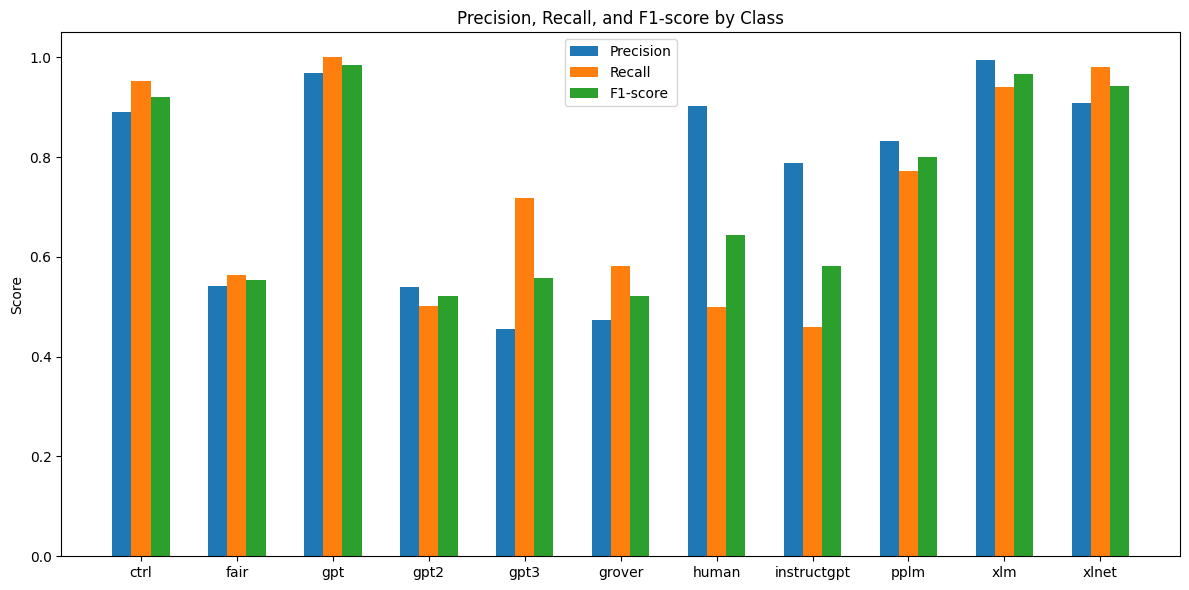

In [8]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_encoded, y_pred)

# Get the class labels
class_labels = label_encoder.classes_

# Plot the results as a bar plot
x = np.arange(len(class_labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

fig.tight_layout()

plt.show()
